# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "balanced"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 1
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.optim.max_iterations = 0

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
 

In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 0
        step_size_decay: 

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [13]:
# reconstruct gt features from users
cfg.case.user.num_data_points = 1
gt_features = []
for i in tqdm(range(50 // cfg.case.user.num_data_points)):
    with open_dict(cfg):
        cfg.case.user.user_idx = i
    user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)  
    gt_features.append(torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain)).cpu().detach().numpy())

gt_features = np.array(gt_features)

100%|███████████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/it]


In [140]:
# reconstruct sampling features from users
cfg.case.user.num_data_points = 2
all_features = []
for i in tqdm(range(50 // cfg.case.user.num_data_points)):
    with open_dict(cfg):
        cfg.case.user.user_idx = i
    user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)  
    all_features.append(torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain)).cpu().detach().numpy())

all_features = np.array(all_features)

100%|█████████████████████████████████████| 25/25 [00:45<00:00,  1.82s/it]


In [141]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

### Reconstruct user data:

In [142]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [143]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

/Users/ywen/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:156: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


Optimal candidate solution with rec. loss 0.9176 selected.


In [11]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

D:\anaconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0092 | PSNR: 20.38 | FMSE: 1.7127e+03 | LPIPS: 0.34|
 R-PSNR: 20.51 | IIP-pixel: 100.00% | SSIM: 0.4455 | Label Acc: 100.00%


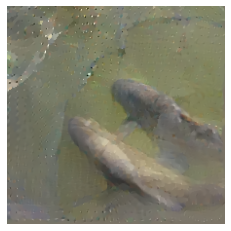

In [12]:
user.plot(reconstructed_user_data)

0.29775277 0.35939962


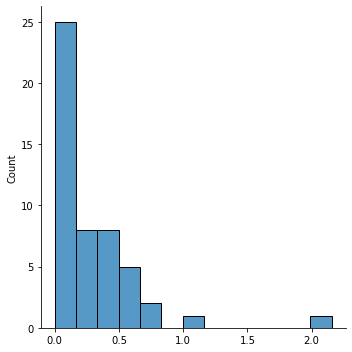

In [117]:
f_ind = 9
tmp_series = gt_features[:, f_ind]
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series))

0.3370758 0.45846245


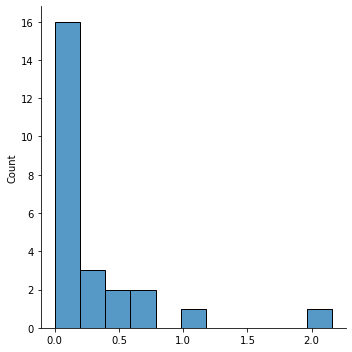

In [118]:
tmp_series = all_features[:, f_ind]
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series))

In [132]:
results = []
for gt_feat in gt_features:
    results.append(float(server.model.model.fc(torch.tensor(gt_feat))[0]))

In [136]:
np.percentile(results, 10, axis=0)

237.74906311035156

In [ ]:
server.reset_model()
server.reconfigure_model('cls_attack', extra_info=extra_info)
with torch.no_grad():
    *_, l_w, l_b = server.model.parameters()
    l_w.copy_(l_w * 1)

In [137]:
server.model.model.fc(torch.tensor(np.percentile(gt_features, 10, axis=0).astype(gt_features.dtype)))[0]

tensor(78.4367, grad_fn=<SelectBackward0>)

In [156]:
reconstructed_user_data

{'data': tensor([[[[0.3319, 0.5145, 0.9131,  ..., 0.5145, 0.9131, 0.7046],
           [0.2715, 0.6704, 0.1125,  ..., 0.6704, 0.1125, 0.1656],
           [0.1694, 0.6345, 0.7792,  ..., 0.6345, 0.7792, 0.2684],
           ...,
           [0.2715, 0.6704, 0.1125,  ..., 0.6704, 0.1125, 0.1656],
           [0.1694, 0.6345, 0.7792,  ..., 0.6345, 0.7792, 0.2684],
           [0.6608, 0.5216, 0.9534,  ..., 0.5216, 0.9534, 0.9128]],
 
          [[0.2906, 0.9987, 0.2892,  ..., 0.9987, 0.2892, 0.9851],
           [0.0942, 0.7262, 0.8576,  ..., 0.7262, 0.8576, 0.4660],
           [0.6358, 0.9603, 0.5839,  ..., 0.9603, 0.5839, 0.8928],
           ...,
           [0.0942, 0.7262, 0.8576,  ..., 0.7262, 0.8576, 0.4660],
           [0.6358, 0.9603, 0.5839,  ..., 0.9603, 0.5839, 0.8928],
           [0.6224, 0.7328, 0.7220,  ..., 0.7328, 0.7220, 0.0988]],
 
          [[0.3981, 0.3817, 0.9250,  ..., 0.3817, 0.9250, 0.0507],
           [0.9777, 0.6519, 0.4781,  ..., 0.6519, 0.4781, 0.4702],
           [0.97

In [161]:
target_indx = np.where(t_labels == 0)

In [162]:
t_labels[target_indx]

array([0])

In [165]:
shared_data['metadata']['labels'][[0, 1]]

tensor([0, 1])

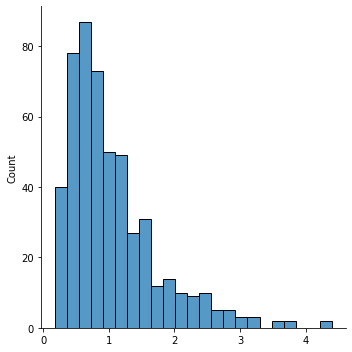

In [174]:
tmp_series = np.mean(all_features, axis=0)
sns.displot(tmp_series)

In [176]:
shared_data.keys()

dict_keys(['gradients', 'buffers', 'metadata'])